In [ ]:

!pip install pyspark
!pip install spark-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.4/725.4 kB 9.3 MB/s eta 0:00:00


In [ ]:
# 1. Setup PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BBCNewsTopicModeling").getOrCreate()

In [ ]:
# Load the data into a Pandas DataFrame
import pandas as pd
bbcdata="/content/bbc-text.csv"
df_bbc = pd.read_csv(bbcdata)
df_bbc.columns = ['CATEGORY', 'Text']

In [ ]:
# Display first few records
df_bbc.head()

,CATEGORY,Text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_bbc['CATEGORY'].value_counts()

,count
CATEGORY,
sport,511
business,510
politics,417
tech,401
entertainment,386


In [ ]:
df_spark = spark.createDataFrame(df_bbc[['CATEGORY', 'Text']])

In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

tokenizer = RegexTokenizer(inputCol="Text", outputCol="words", pattern="\\W")
df_tokens = tokenizer.transform(df_spark)

stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_filtered = stopwords_remover.transform(df_tokens)

df_filtered.select("text", "filtered").show(3, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                                text|                                                                                            filtered|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digi...|[tv, future, hands, viewers, home, theatre, systems, plasma, high, definition, tvs, digital, vide...|
|worldcom boss  left books alone  former worldcom boss bernie ebbers  who is accused of overseeing...|[worldcom, boss, left, books, alone, former, worldcom, boss, bernie, ebbers, accus

In [ ]:
# 5. Feature Extraction - CountVectorizer
from pyspark.ml.feature import CountVectorizer
#t’s used to convert a collection of text tokens (already tokenized)
#into a sparse feature vector of token counts.
#At this point, df_cv contains a new column called "features_cv",
#which holds the SparseVector of token counts for each document.
cv = CountVectorizer(inputCol="filtered", outputCol="features_cv", \
                     vocabSize=5000, minDF=5)
cv_model = cv.fit(df_filtered)
df_cv = cv_model.transform(df_filtered)

print(f"Vocabulary size (CountVectorizer): {len(cv_model.vocabulary)}")
print(f"Sample vocabulary words: {cv_model.vocabulary[:10]}")
print("Vector count")
df_cv.select("features_cv").show(truncate=False)

Vocabulary size (CountVectorizer): 5000
Sample vocabulary words: ['said', 'mr', 'year', 'also', 'people', 'new', 'us', 'one', 'last', 'first']
Vector count
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import SparseVector
from pyspark.sql.types import MapType, StringType, IntegerType

# Get the learned vocabulary
vocab = cv_model.vocabulary

# Define a UDF to convert SparseVector to {word: count}
def vector_to_wordcount(vector):
    return {vocab[i]: int(c) for i, c in zip(vector.indices, vector.values)}

vector_to_wordcount_udf = udf(vector_to_wordcount, MapType(StringType(), IntegerType()))
df_counts = df_cv.withColumn("word_counts", vector_to_wordcount_udf("features_cv"))

df_counts.select("filtered", "word_counts").show(truncate=False)
print("Total documents:")
df_counts.select("filtered").count()

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2225

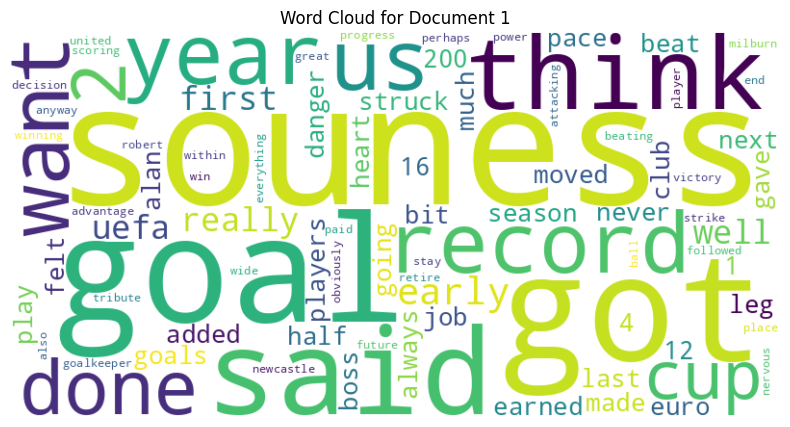

In [ ]:
# 4. Collect word counts for a specific document (e.g., first row)
wordcount_dict = df_counts.select("word_counts").collect()[2224][0]
# 5. Generate word cloud locally using Python libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcount_dict)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Document 1")
plt.show()

In [ ]:
# 6. Feature Extraction - TF-IDF
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=5000)
df_featurized = hashingTF.transform(df_filtered)

idf = IDF(inputCol="rawFeatures", outputCol="features_tfidf")
idf_model = idf.fit(df_featurized)
df_tfidf = idf_model.transform(df_featurized)

In [ ]:
# 7. Build LDA Models
from pyspark.ml.clustering import LDA

num_topics = 5
max_iter = 20

# LDA with CountVectorizer features
lda_cv = LDA(k=num_topics, maxIter=max_iter, featuresCol="features_cv", seed=42)
lda_model_cv = lda_cv.fit(df_cv)

# LDA with TF-IDF features
lda_tfidf = LDA(k=num_topics, maxIter=max_iter, featuresCol="features_tfidf", seed=42)
lda_model_tfidf = lda_tfidf.fit(df_tfidf)

In [ ]:
# 8. Extract and show topics
def show_topics(lda_model, vocab):
    topics = lda_model.describeTopics()
    num_topics = lda_model.describeTopics().count()
    print(f"Number of topics: {num_topics}")
    #.rdd converts the DataFrame into an RDD of rows.
    topics_rdd = topics.rdd
    #.map() applies a function to each row — here, mapping term indices to vocab words.
    topics_words = topics_rdd.map(lambda row: [vocab[word_id] for word_id in row['termIndices']]).collect()
    for idx, topic_words in enumerate(topics_words):
        print(f"Topic {idx+1}: {topic_words}")

print("Topics from CountVectorizer LDA:")
show_topics(lda_model_cv, cv_model.vocabulary)

print("\nTopics from TF-IDF LDA :")
topics_tfidf = lda_model_tfidf.describeTopics().collect()
num_topics = lda_model_tfidf.describeTopics().count()
print(f"Number of topics: {num_topics}")
for idx, topic in enumerate(topics_tfidf):
    #print(f"Topic {idx+1}: {topic['termIndices']}")
    topic_words = [vocab[word_id] for word_id in topic['termIndices']]
    print(f"Topic {idx + 1}: {topic_words}")

Topics from CountVectorizer LDA:
Number of topics: 5
Topic 1: ['said', 'people', 'mobile', 'technology', 'phone', 'users', 'use', 'one', 'new', 'also']
Topic 2: ['said', 'year', '6', 'us', '1', 'economy', 'china', 'growth', 'market', '2']
Topic 3: ['said', 'year', 'mr', 'new', 'also', 'us', 'one', 'time', 'people', 'world']
Topic 4: ['film', 'best', 'award', 'o', 'awards', 'ireland', 'won', 'win', 'england', 'actress']
Topic 5: ['mr', 'said', 'labour', 'election', 'party', 'blair', 'people', 'howard', 'minister', 'also']

Topics from TF-IDF LDA :
Number of topics: 5
Topic 1: ['tribute', 'agreement', 'rich', 'knows', 'pause', 'anderson', 'katerina', 'turning', 'celebrities', 'video']
Topic 2: ['follows', 'away', 'reduce', 'downing', 'david', 'might', 'confirm', 'medallist', 'rich', 'cannes']
Topic 3: ['revenue', 'anthony', 'group', 'gifts', 'patients', 'jazz', 'giants', 'covered', 'branded', 'starts']
Topic 4: ['also', 'gear', 'opportunity', 'iranian', 'monitor', 'speech', 'oxford', 're

In [ ]:
# 9. Evaluate Model (Log Likelihood & Perplexity)
#Measures how well your model explains the observed data.

#Higher (less negative) is better — it means the model fits the data well.
 #perplexity measure of how "surprised" the model is by the data.

#Lower is better — it indicates that the model predicts unseen data more confidently.

#Perplexity is often considered more robust for evaluating topic models.



print("\nEvaluation on CountVectorizer LDA:")
print(f"Log Likelihood: {lda_model_cv.logLikelihood(df_cv)}")
print(f"Perplexity: {lda_model_cv.logPerplexity(df_cv)}")

print("\nEvaluation on TF-IDF LDA:")
print(f"Log Likelihood: {lda_model_tfidf.logLikelihood(df_tfidf)}")
print(f"Perplexity: {lda_model_tfidf.logPerplexity(df_tfidf)}")


Evaluation on CountVectorizer LDA:
Log Likelihood: -3239240.522249136
Perplexity: 7.670890250354947

Evaluation on TF-IDF LDA:
Log Likelihood: -11048845.70146881
Perplexity: 8.037135273499102


In [ ]:
!pip install bertopic
!pip install sentence-transformers umap-learn hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 836.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Basic cleanup if needed
df_bbc["clean_text"] = df_bbc["Text"].str.lower().str.replace(r'\W+', ' ', regex=True)
docs = df_bbc["clean_text"].tolist()

In [32]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load embedding model (you can change to 'all-mpnet-base-v2' or others)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Create BERTopic instance
topic_model = BERTopic(embedding_model=embedding_model)

# Fit and transform
topics, probs = topic_model.fit_transform(docs)

In [33]:
# Show top 5 topics
topic_model.get_topic_info().head()

# Example: words in topic 0
topic_model.get_topic(0)
topic_model.visualize_topics()

In [34]:
# 11. Stop Spark session
spark.stop()